<a href="https://colab.research.google.com/github/matthewreader/continuous-learning/blob/main/books/deep-learning-with-pytorch/Deep_Learning_with_PyTorch_Chapter_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The model created in Chapter 7 was good at memorizing the training data, but not great at generalizing to the validation data set.  

In [1]:
import torch
from google.colab import drive
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
from matplotlib import pyplot as plt

drive.mount('/content/gdrive')
GDRIVE_DATA = "gdrive/My Drive/Colab Notebooks/Data/deep-learning-with-pytorch"

data_path = GDRIVE_DATA + '/p1ch7/'

tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                         transform=transforms.ToTensor())
tensor_cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                         transform=transforms.ToTensor())

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
         for img, label in tensor_cifar10
         if label in [0, 2]]
cifar2_val = [(img, label_map[label])
             for img, label in tensor_cifar10_val
             if label in [0, 2]]

Mounted at /content/gdrive


In [2]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [3]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

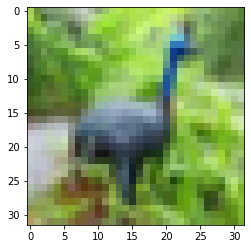

In [4]:
# Original color image
plt.imshow(img.permute(1, 2, 0))
plt.show()

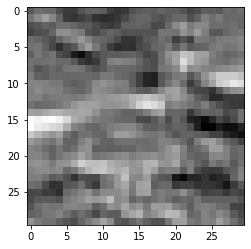

In [5]:
# Convolution output
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

Our output convolution shrank.  We can get back to a 32 x 32 output by using padding with an odd sized kernal

In [6]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

Example of an edge detection kernal that will highlight vertical edges between two horizontally adjacent regions.

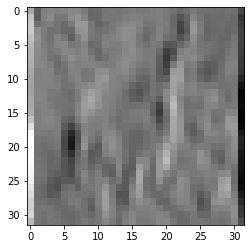

In [7]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
   conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                  [-1.0, 0.0, 1.0],
                                  [-1.0, 0.0, 1.0]])
   conv.bias.zero_()

output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

Down sampling of images between successive convolutions.  The combination of convolutions and downsampling is what will help our network identify larger structures and achieve position invariance of our input images.

In [8]:
pool = nn.MaxPool2d(2) # Downsample image by half
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

Updating our model with convolutions and max pooling

In [9]:
# In[23]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

We could also subclass `nn.Module` to create our model.  This allows us to use the `view` method to reshape our tensor, which is not possible using `nn.Sequential`.

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [11]:
model = Net()
model(img.unsqueeze(0))

tensor([[0.1665, 0.0164]], grad_fn=<AddmmBackward0>)

In [12]:
# In[30]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
             outputs = model(imgs)
             loss = loss_fn(outputs, labels)
             optimizer.zero_grad()
             loss.backward()
             optimizer.step()
             loss_train += loss.item()
 
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [13]:
# In[31]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
 
model = Net()  #
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)  #
loss_fn = nn.CrossEntropyLoss()  #
 
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-01-07 21:29:24.058447 Epoch 1, Training loss 0.6809182482160581
2022-01-07 21:29:59.278888 Epoch 10, Training loss 0.4632644564103169
2022-01-07 21:30:38.654980 Epoch 20, Training loss 0.35927152776034776
2022-01-07 21:31:18.330350 Epoch 30, Training loss 0.32546425919244243
2022-01-07 21:31:58.468897 Epoch 40, Training loss 0.3048108479209766
2022-01-07 21:32:37.754662 Epoch 50, Training loss 0.2863900598826682
2022-01-07 21:33:16.571235 Epoch 60, Training loss 0.2714612551365688
2022-01-07 21:33:55.777765 Epoch 70, Training loss 0.2578164589632848
2022-01-07 21:34:35.493903 Epoch 80, Training loss 0.2473812000292122
2022-01-07 21:35:14.855472 Epoch 90, Training loss 0.23515567249932867
2022-01-07 21:35:53.832687 Epoch 100, Training loss 0.22611684878920293


In [14]:
# In[32]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
 
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
 
        print("Accuracy {}: {:.2f}".format(name , correct / total))
 
validate(model, train_loader, val_loader)

Accuracy train: 0.91
Accuracy val: 0.88


Saving the weights of our model and then loading the weights back to a new instance.

In [15]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [16]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

Training on a GPU instead of CPU can speed up training.

In [17]:
import torch
device = (torch.device('cuda') if torch.cuda.is_available()
         else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [18]:
import datetime
 
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
 
            loss_train += loss.item()
 
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

Adding L2 regularization

In [20]:
# In[45]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
 
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
 
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

Adding Dropout

In [21]:
# In[47]:
class NetDropout(nn.Module):
   def __init__(self, n_chans1=32):
       super().__init__()
       self.n_chans1 = n_chans1
       self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
       self.conv1_dropout = nn.Dropout2d(p=0.4)
       self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                              padding=1)
       self.conv2_dropout = nn.Dropout2d(p=0.4)
       self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
       self.fc2 = nn.Linear(32, 2)

   def forward(self, x):
       out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
       out = self.conv1_dropout(out)
       out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
       out = self.conv2_dropout(out)
       out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
       out = torch.tanh(self.fc1(out))
       out = self.fc2(out)
       return out

Adding batch normalization

In [23]:
class NetBatchNorm(nn.Module):
   def __init__(self, n_chans1=32):
       super().__init__()
       self.n_chans1 = n_chans1
       self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
       self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
       self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                              padding=1)
       self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
       self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
       self.fc2 = nn.Linear(32, 2)

   def forward(self, x):
       out = self.conv1_batchnorm(self.conv1(x))
       out = F.max_pool2d(torch.tanh(out), 2)
       out = self.conv2_batchnorm(self.conv2(out))
       out = F.max_pool2d(torch.tanh(out), 2)
       out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
       out = torch.tanh(self.fc1(out))
       out = self.fc2(out)
       return out

Adding skip connections

In [27]:
# In[51]:
class NetDepth(nn.Module):
   def __init__(self, n_chans1=32):
       super().__init__()
       self.n_chans1 = n_chans1
       self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
       self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                              padding=1)
       self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                              kernel_size=3, padding=1)
       self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
       self.fc2 = nn.Linear(32, 2)

   def forward(self, x):
       out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
       out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
       out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
       out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
       out = torch.relu(self.fc1(out))
       out = self.fc2(out)
       return out

class NetRes(nn.Module):
   def __init__(self, n_chans1=32):
       super().__init__()
       self.n_chans1 = n_chans1
       self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
       self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                              padding=1)
       self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                              kernel_size=3, padding=1)
       self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
       self.fc2 = nn.Linear(32, 2)

   def forward(self, x):
       out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
       out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
       out1 = out
       out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
       out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
       out = torch.relu(self.fc1(out))
       out = self.fc2(out)
       return out

Creating a very deep network with building blocks

In [26]:
# In[55]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
 
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

class NetResDeep(nn.Module):
   def __init__(self, n_chans1=32, n_blocks=10):
       super().__init__()
       self.n_chans1 = n_chans1
       self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
       self.resblocks = nn.Sequential(
           *(n_blocks * [ResBlock(n_chans=n_chans1)]))
       self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
       self.fc2 = nn.Linear(32, 2)

   def forward(self, x):
       out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
       out = self.resblocks(out)
       out = F.max_pool2d(out, 2)
       out = out.view(-1, 8 * 8 * self.n_chans1)
       out = torch.relu(self.fc1(out))
       out = self.fc2(out)
       return out